In [4]:
import logging
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

USE_GPU = False

if USE_GPU:
    import manage_gpus as gpl

    gpl.get_gpu_lock()
import activation_learner
import pytorch_nmf
import param_estimator
import plot
from mixes.unmixdb import UnmixDB
from mixes.synthetic import SyntheticDB
import carve
import torch

In [10]:
# dataset = UnmixDB(
#     "/data2/anasynth_nonbp/schwarz/abc-dj/data/unmixdb-zenodo/"
# )  # inverno
# dataset = UnmixDB("/data2/anasynth_nonbp/andre/unmixdb-zenodo") # guqin
dataset = SyntheticDB()
FS = 22050
# mix = dataset.mixes[4]
mix = dataset.mixes[1]
logger = logging.getLogger(mix.name)
logging.basicConfig()
logger.setLevel(logging.DEBUG)
logger.info(mix.name)

inputs = [track.audio for track in mix.tracks] + [mix.audio]

INFO:linear-mix-desync:linear-mix-desync


INFO:linear-mix-desync:Starting round with hop_size=1s, win_size=8s


/data5/anasynth_nonbp/andre/venv/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=176400 is too large for input signal of length=165375
  warnings.warn(
Loss=8.49e-04, dLoss = 2.34e-08: 100%|██████████| 2000/2000 [00:01<00:00, 1536.38it/s]


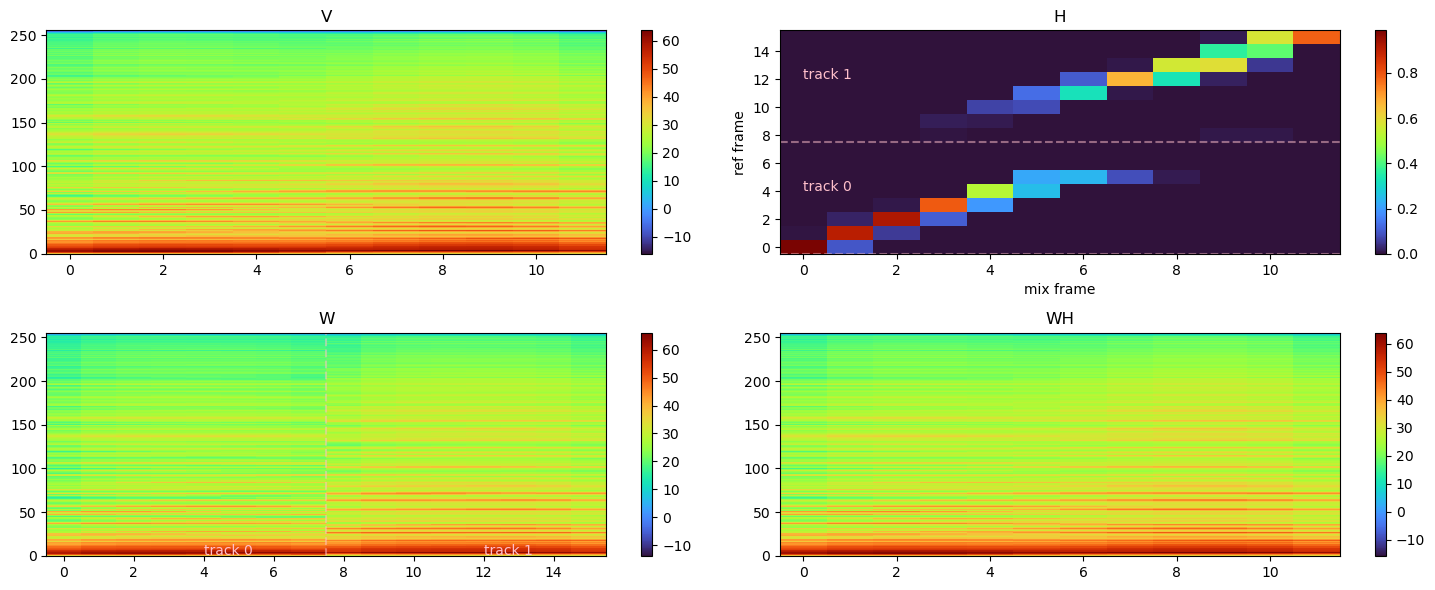

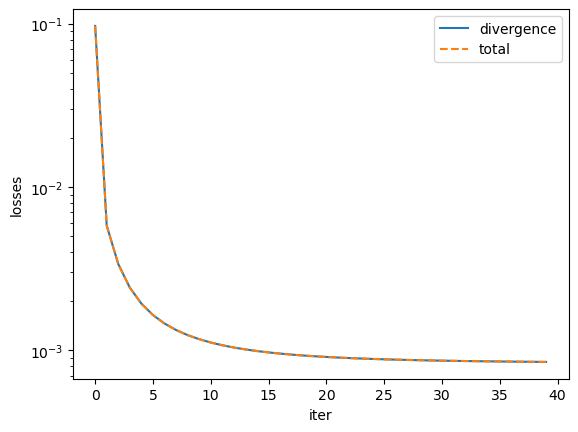

INFO:linear-mix-desync:Starting round with hop_size=0.5s, win_size=4.0s


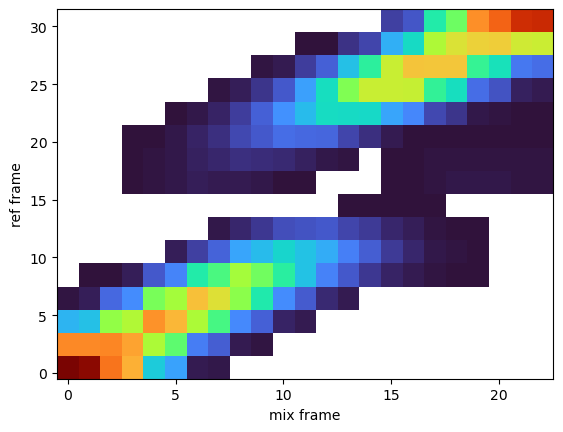

Loss=5.69e-04, dLoss = 2.27e-08: 100%|██████████| 2000/2000 [00:01<00:00, 1351.17it/s]


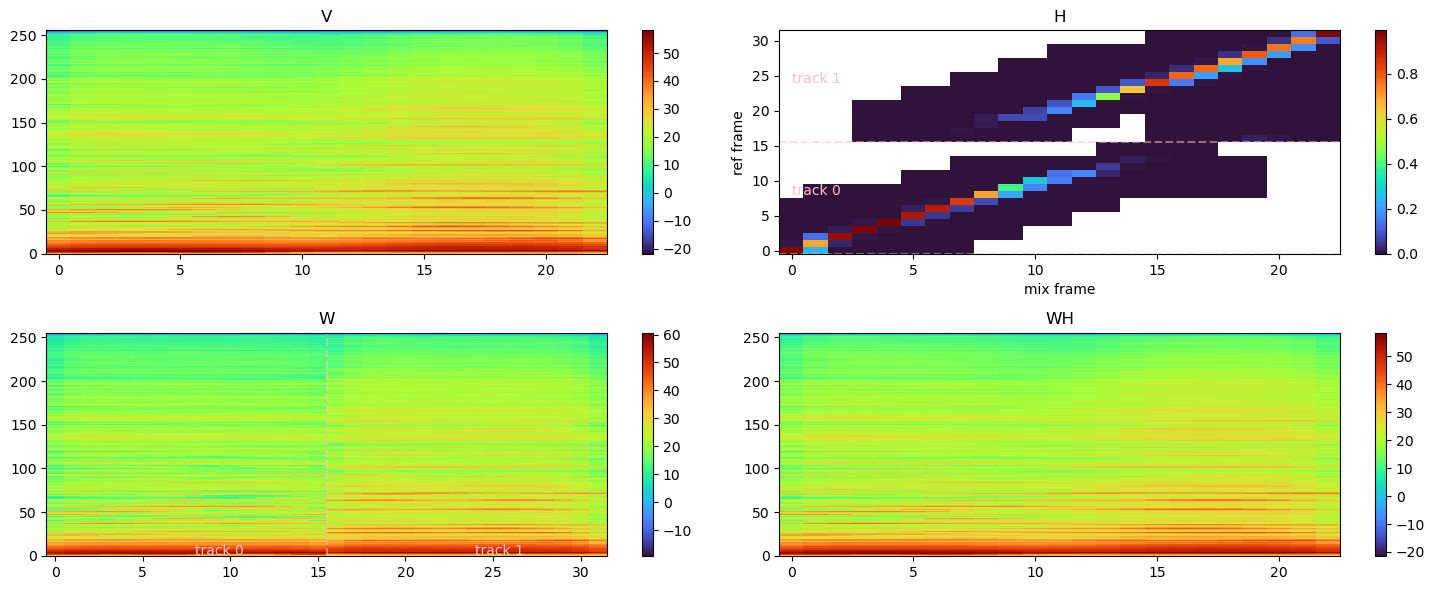

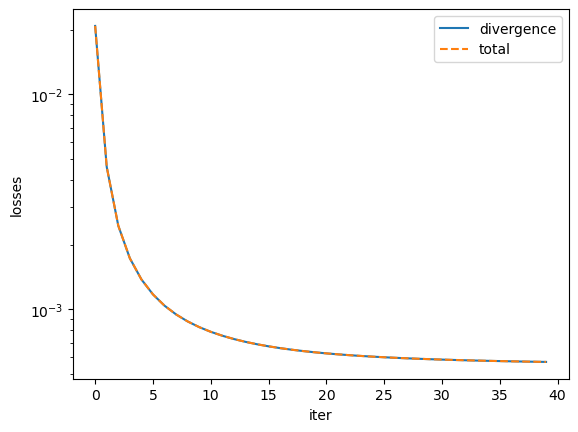

INFO:linear-mix-desync:Starting round with hop_size=0.1s, win_size=0.8s


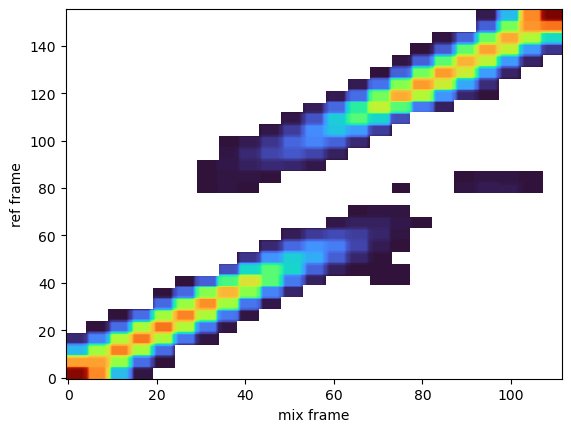

Loss=1.36e-03, dLoss = 9.24e-09:  82%|████████▎ | 1650/2000 [00:03<00:00, 471.32it/s]


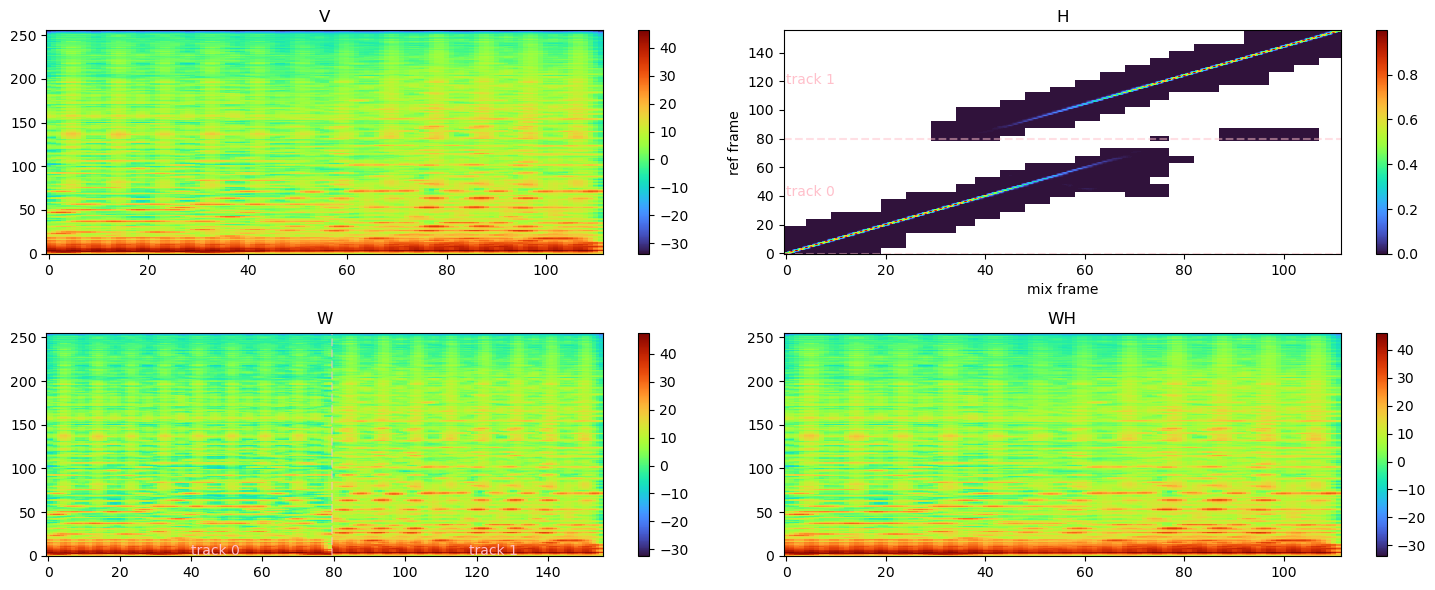

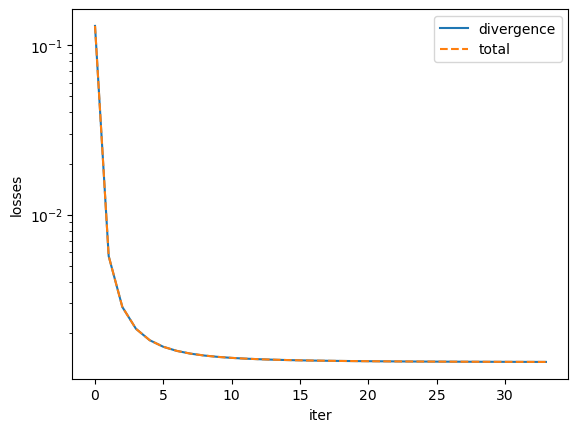

In [11]:
hops = [1, 0.5, 0.1]
overlap = 8
nmels = 256
low_power_threshold = 0.01
spec_power = 2
learners: list[activation_learner.ActivationLearner] = []

for hop_size in hops:
    win_size = hop_size * overlap
    divergence = pytorch_nmf.BetaDivergence(0)
    penalties = (
        [
            # (pytorch_nmf.L1(), 1e-1),
            # (pytorch_nmf.SmoothDiago(), 0.0638),
            # (pytorch_nmf.SmoothOverCol(), 0.00034),
            # (pytorch_nmf.SmoothOverRow(), 0.00171),
            # (pytorch_nmf.Lineness(), 1e8),
        ]
        if hop_size == hops[-1]
        else []
    )

    logger.info(f"Starting round with {hop_size=}s, {win_size=}s")

    learner = activation_learner.ActivationLearner(
        inputs,
        fs=FS,
        n_mels=nmels,
        win_size=win_size,
        hop_size=hop_size,
        penalties=penalties,
        divergence=divergence,
        low_power_threshold=low_power_threshold,
        use_gpu=USE_GPU,
        spec_power=spec_power,
        stft_win_func="barthann",
    )

    # carve and resize H from previous round
    if len(learners) > 0:
        new_H = carve.resize_then_carve(
            learners[-1].H,
            learner.H.shape,
            learners[-1].split_idx,
            1e-3,
            3,
            diag_size=2,
            max_slope=2,
            n_filters=7,
        )
        plt.figure("H after resizing and carving")
        plot.plot_H(new_H.cpu().detach().numpy())
        plt.show()

        learner.H = new_H

    loss_history = learner.fit(2000, dloss_min=1e-8)

    torch.save(learner.H, f"H_{hop_size:.2f}.torch")
    plot.plot_nmf(learner)
    plt.show()
    fig = plt.figure()
    plot.plot_loss_history(loss_history)
    plt.show()

    learners.append(learner)

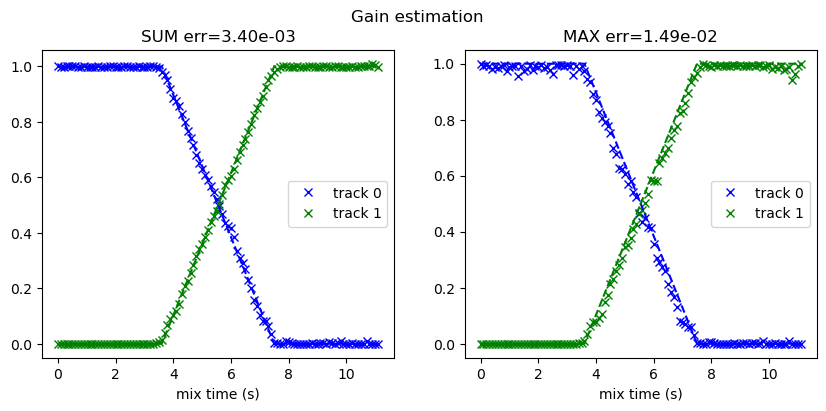

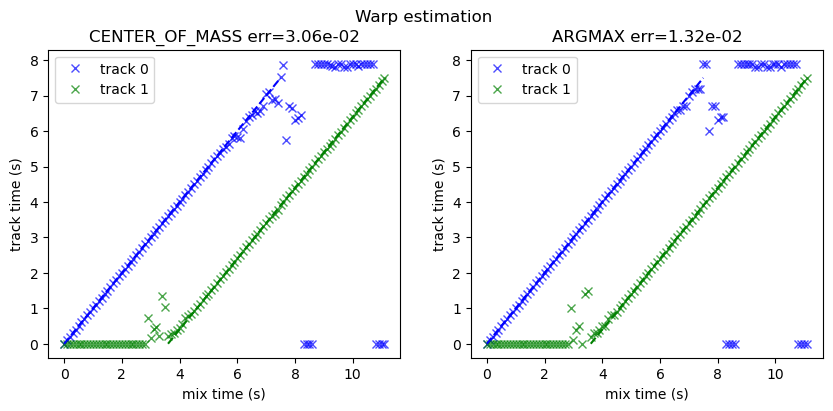

In [12]:
import scipy.ndimage
import scipy.signal

GAIN_ESTORS = [
    param_estimator.GainEstimator.SUM,
    param_estimator.GainEstimator.MAX,
]
WARP_ESTORS = [
    param_estimator.WarpEstimator.CENTER_OF_MASS,
    param_estimator.WarpEstimator.ARGMAX,
]
#############
# estimations

# get ground truth
tau = np.arange(0, learner.V.shape[1]) * hop_size
real_gain = mix.gain(tau)
real_warp = mix.warp(tau)

fig, axes = plt.subplots(1, len(GAIN_ESTORS))
fig.set_size_inches(5 * len(GAIN_ESTORS), 4)
fig.suptitle("Gain estimation")
for i, estor in enumerate(GAIN_ESTORS):
    est_gain = estor(learner.H, learner.split_idx, spec_power)
    # est_gain = scipy.signal.savgol_filter(est_gain, 15, 3, axis=0)
    err_gain = param_estimator.error(est_gain, real_gain)
    plot.plot_gain(tau, est_gain, real_gain, ax=axes[i])
    axes[i].set_title(f"{estor.__name__} err={err_gain:.2e}")
plt.show()

fig, axes = plt.subplots(1, len(WARP_ESTORS))
fig.set_size_inches(5 * len(WARP_ESTORS), 4)
fig.suptitle("Warp estimation")
for i, estor in enumerate(WARP_ESTORS):
    est_warp = estor(learner.H, learner.split_idx, hop_size)
    # est_warp = scipy.signal.savgol_filter(est_warp, 15, 2, axis=0)
    err_warp = param_estimator.error(est_warp, real_warp)
    plot.plot_warp(tau, est_warp, real_warp, ax=axes[i])
    axes[i].set_title(f"{estor.__name__} err={err_warp:.2e}")
plt.show()

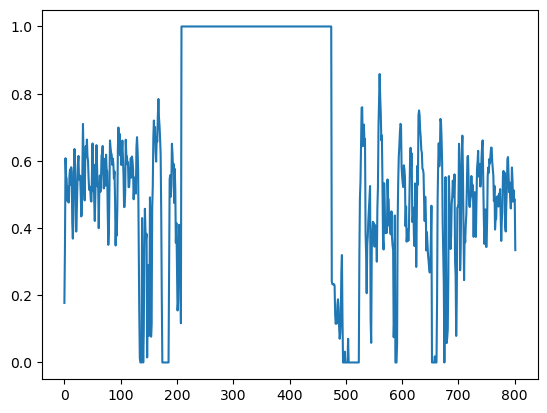

In [ ]:
plt.plot(abs(est_gain - real_gain))

KeyboardInterrupt: 

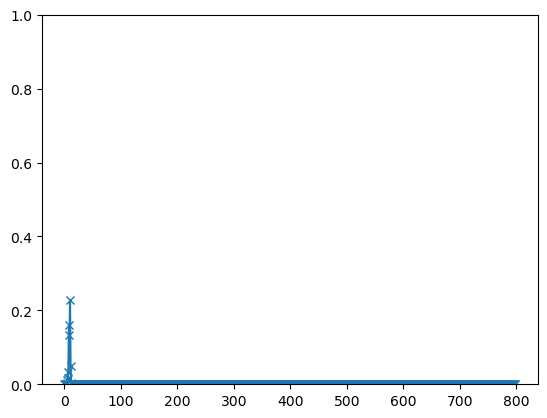

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import Video, display

fig, ax = plt.subplots()
ax.set_ylim(0, learner.H.detach().numpy().max())
(line,) = ax.plot(learner.H[:, 0].detach().numpy(), "x-")


def update(i):
    line.set_ydata(learner.H[:, i].detach().numpy())
    return (line,)


ani = animation.FuncAnimation(
    fig, update, frames=range(learner.H.shape[1]), blit=True, interval=int(1000 / 30)
)

ani.save("animation.mp4", writer="ffmpeg")
display(Video("animation.mp4"))